## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem description

We will work with the __abalone__ dataset, where we wan to predict the number of rings in abalones, which should correspond to the age. 

# Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
class_problem = config["class_problem"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




#---------DATA------------
df = pd.read_csv("abalone.csv")
df = pd.get_dummies(df, drop_first=True)*1
#df = df.drop(["Sex"])
variable_names = list(df.loc[:,df.columns != "Rings"].columns)
X_original = df.loc[:,df.columns != "Rings"].values
y_original = df.loc[:,df.columns == "Rings"].values.T[0]
n, p = X_original.shape  # need this to get p 

print(n,p)

# Define BATCH sizes
BATCH_SIZE = int((n*0.8)/5)
TEST_BATCH_SIZE = int(n*0.10) 
VAL_BATCH_SIZE = int(n*0.10)

TRAIN_SIZE = int((n*0.80)/5)
TEST_SIZE = int(n*0.10)
VAL_SIZE = int(n*0.10)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

4177 9


# ReLU based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu_lime_shap", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

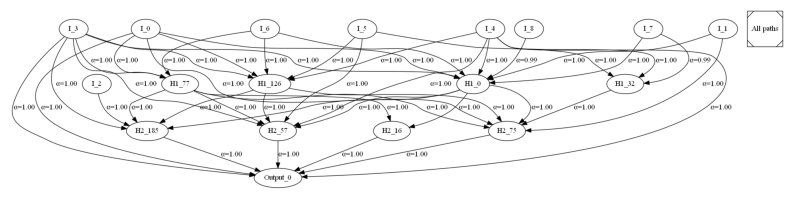

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/lrt/prob/test0_relu_lime_shap.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 44 weights used in median model $\rightarrow$ density of 0.1\% compared to initialized model (43'809 weigths) 
* RMSE of 2.06 for median model
* RMSE of 13.94 for full model (did 1000 epochs of post-training with median prob model)

## Weight graph

In [6]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu_lime_shap", show=False)

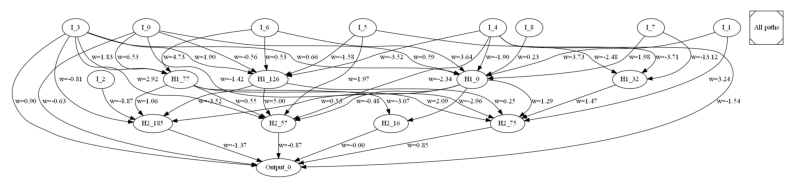

In [7]:
img = mpimg.imread("path_graphs/lrt/weight/temp_relu_lime_shap.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Local contribution

### LIME code

In [39]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_lime(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    if len(x.shape) == 1:
        preds = np.zeros((1000, 1, 1))
    else:
        preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
            # preds[samp, :, 0] = 1 - preds[samp, :, 1]
    preds = preds.mean(0)
    return preds

def explain_lime(indx, X_test, feature_names=variable_names, class_names=["rings"]):
    # Assuming `X_train` is your training data and `class_names` are the names of the classes
    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='regression'
    )
    # Explain a single instance
    exp = explainer.explain_instance(
        data_row=X_test[indx],
        predict_fn=batch_predict_lime,
        num_features=len(variable_names),  # Number of features to include in the explanation
        num_samples=2_000
    )
    return exp


def plot_lime_explain(exp, indx, class_label=1, names_features=variable_names):
    # Extract feature importances for a specific class
    feature_importances = dict(exp.as_map()[class_label])

    # Ensure the feature importances are in the correct order
    ordered_importances = [feature_importances[indx] for indx in range(len(names_features))]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
    plt.ylabel('LIME importance')
    plt.xlabel('Feature')
    plt.title(f'LIME feature importances for Class {class_label} (instance {indx})')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

#### SHAP code

In [40]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_shap(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
    preds = preds.mean(0)
    return preds


def shap_explain(X_test, i):
    # Create SHAP explainer
    explainer = shap.Explainer(batch_predict_shap, X_train)
    # Index of the instance you want to explain

    # Explain the instance
    shap_vals = explainer(X_test[i:i+1], max_evals=1_000, batch_size=256)
    return shap_vals

def plot_shap_explain(shap_vals, i, feature_names = variable_names):
    # Plot bar plot of SHAP values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.title(f'SHAP values for instance {i}. Baseline: {shap_vals.base_values[0][0]:.4f}')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

### Number of rings: 10 

#### Empirical approach

True class: 10.0


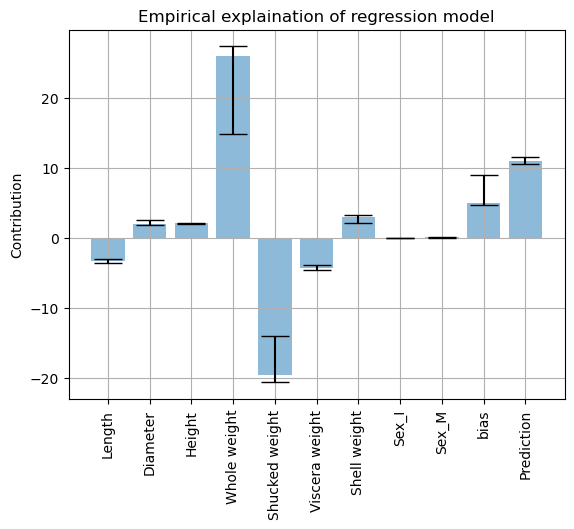

In [21]:
i = 106
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=variable_names)

#### Lime explanation

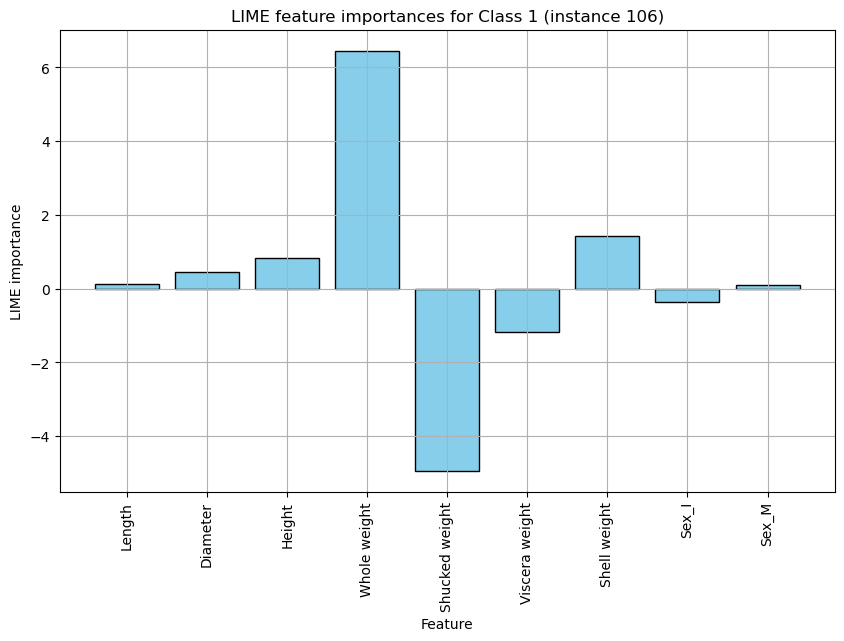

In [41]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [42]:
exp.local_exp[1]

[(3, 6.453952504187091),
 (4, -4.935135822847026),
 (6, 1.4221192722553933),
 (5, -1.1785262532413963),
 (2, 0.8375775945109258),
 (1, 0.44530922229296244),
 (7, -0.3578690699259404),
 (0, 0.13229058093159582),
 (8, 0.10544000017504004)]

#### SHAP explanation

Exact explainer: 2it [12:06, 726.09s/it]              


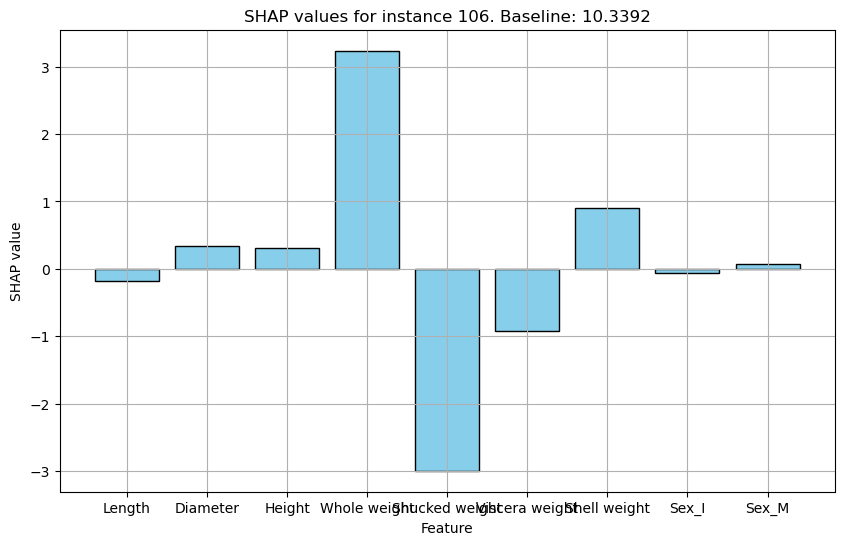

In [37]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [38]:
shap_vals

.values =
array([[-0.18278458,  0.33451864,  0.31626251,  3.23521237, -2.99228017,
        -0.9144939 ,  0.90645632, -0.06385353,  0.07372329]])

.base_values =
array([[10.33922168]])

.data =
array([[0.635 , 0.475 , 0.17  , 1.1935, 0.5205, 0.2695, 0.3665, 0.    ,
        1.    ]])

### Number of rings: 17

#### Empirical approach

True class: 17.0


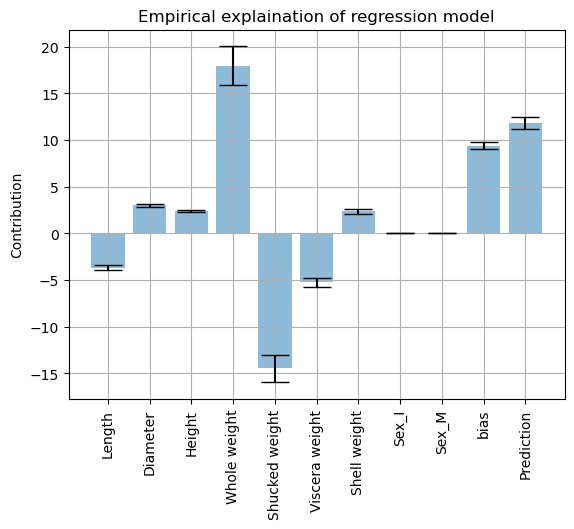

In [56]:
i = 201
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=variable_names)

#### Lime explanation

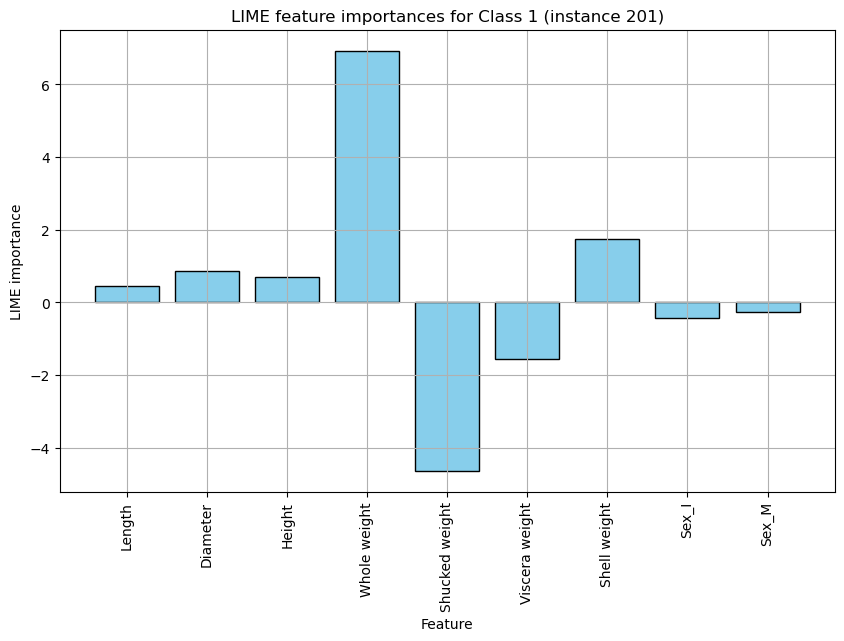

In [57]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [58]:
exp.local_exp[1]

[(3, 6.926402212630169),
 (4, -4.629434499675247),
 (6, 1.7390269034278825),
 (5, -1.56020807858874),
 (1, 0.8734568759373784),
 (2, 0.6979900954543705),
 (0, 0.447122996511865),
 (7, -0.4438108138048554),
 (8, -0.25503129535635033)]

#### SHAP explanation

Exact explainer: 2it [08:14, 494.22s/it]              


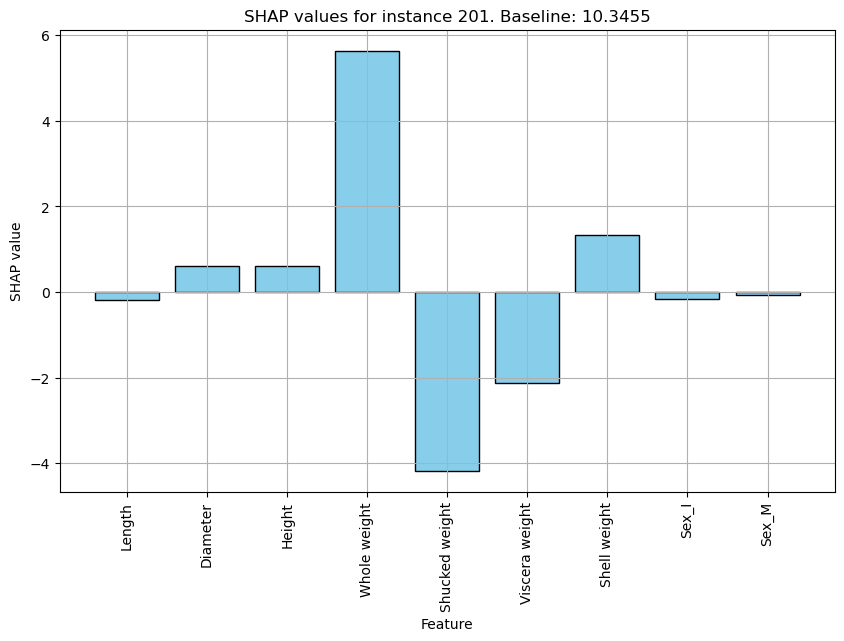

In [59]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [60]:
shap_vals

.values =
array([[-0.18883623,  0.60911823,  0.61541556,  5.63924627, -4.1744117 ,
        -2.11994893,  1.33281712, -0.16889445, -0.0646661 ]])

.base_values =
array([[10.34553127]])

.data =
array([[0.66  , 0.52  , 0.2   , 1.676 , 0.673 , 0.4805, 0.45  , 0.    ,
        0.    ]])

### Number of rings: 8

#### Empirical approach

True class: 8.0


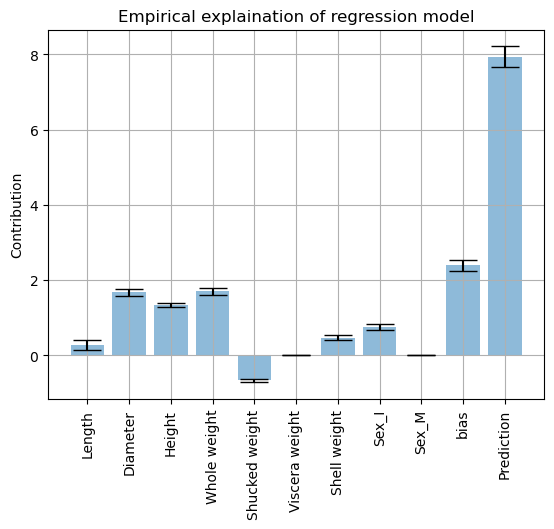

In [45]:
i = 200
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=variable_names)

#### Lime explanation

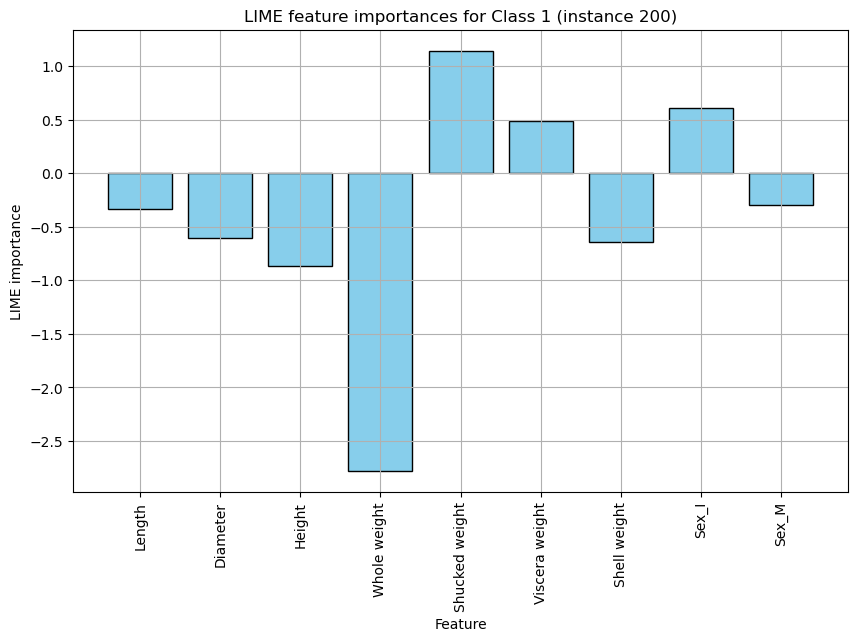

In [46]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [47]:
exp.local_exp[1]

[(3, -2.777555335796598),
 (4, 1.1435432517988946),
 (2, -0.8642443802642591),
 (6, -0.6393067788907101),
 (7, 0.608001593774826),
 (1, -0.6060226226119064),
 (5, 0.48877336367947927),
 (0, -0.3383177278910366),
 (8, -0.29681616400253286)]

#### SHAP explanation

Exact explainer: 2it [10:40, 640.20s/it]              


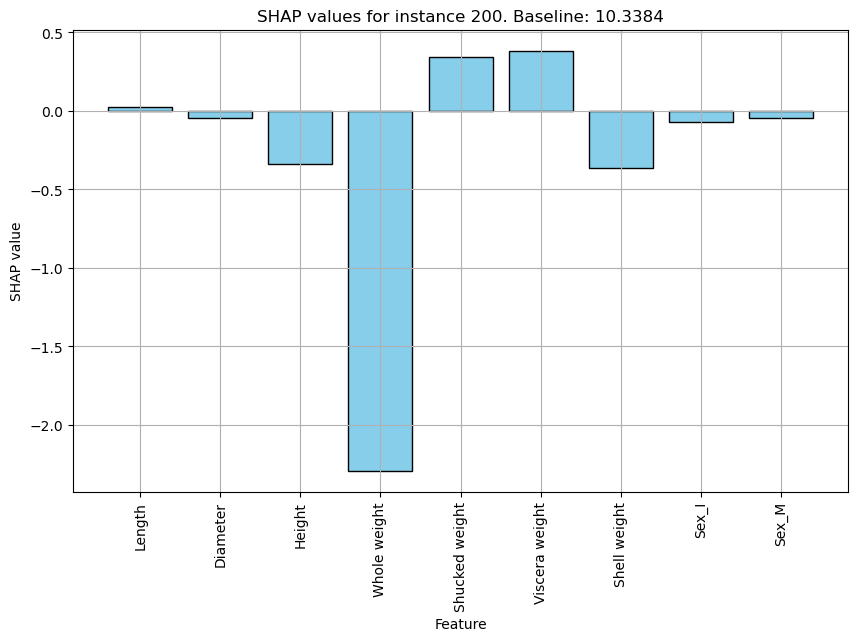

In [48]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [ ]:
shap_vals